In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
bin_count = 171
def create_test_train(data_set_path, test_size=0.10):
    """ Splits a given csv file into testing and training. Target column is all the bins."""
    # Make sure the columns are set
    data_set = pd.read_csv(data_set_path)

    # Add column for classifying whether the output has most of the data in the last 10 bins.
    end_average = data_set[[f'Output_Bin_{i}' for i in range(bin_count-10, bin_count)]].sum(axis=1) > 0.9

    data_set['Output_Is_End'] = end_average
    data_set['Output_Is_End'] = data_set['Output_Is_End'].astype(int)

    # Shuffle the data
    data_set = data_set.sample(frac=1, random_state=0)
 
    # Select all except output bins
    data_set_X = data_set.drop([f'Output_Bin_{i}' for i in range(bin_count)] + ['Output_Is_End'], axis=1)
    # Select only the output bins
    data_set_Y = data_set[[f'Output_Bin_{i}' for i in range(bin_count)]+ ['Output_Is_End']]

    #Split into training and test data
    return train_test_split(data_set_X,
                            data_set_Y,
                            test_size=test_size, 
                            random_state=300)

filename= "/project/SDS-capstones-kropko21/uva-astronomy/dust_training_data_all_bins_v2.csv"
X_train, X_test, y_train, y_test = create_test_train(filename, test_size=0.10)
display(y_test.describe())

,Output_Bin_0,Output_Bin_1,Output_Bin_2,Output_Bin_3,Output_Bin_4,Output_Bin_5,Output_Bin_6,Output_Bin_7,Output_Bin_8,Output_Bin_9,...,Output_Bin_162,Output_Bin_163,Output_Bin_164,Output_Bin_165,Output_Bin_166,Output_Bin_167,Output_Bin_168,Output_Bin_169,Output_Bin_170,Output_Is_End
count,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,1.423300e+05,...,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000,142330.000000
mean,4.788404e-03,3.511234e-03,3.102781e-03,3.476701e-03,3.457728e-03,3.501525e-03,3.642096e-03,3.778553e-03,3.935451e-03,4.021584e-03,...,0.001252,0.001058,0.000883,0.000728,0.000676,0.001939,0.005278,0.016270,0.151275,0.167596
std,1.166852e-02,7.803030e-03,6.573299e-03,7.853398e-03,6.781768e-03,6.542634e-03,6.904298e-03,6.660142e-03,7.485042e-03,6.836560e-03,...,0.007059,0.006218,0.005424,0.004790,0.004623,0.006232,0.013469,0.040799,0.326542,0.373509
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.413419e-11,5.957408e-11,2.004835e-10,7.735218e-10,2.203720e-09,4.972974e-09,1.233129e-08,2.641020e-08,5.567167e-08,1.080826e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.091139e-04,1.224256e-04,1.354748e-04,1.791490e-04,2.160863e-04,2.491617e-04,2.911052e-04,3.537974e-04,4.251557e-04,5.010170e-04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.666961e-03,2.534129e-03,2.509944e-03,2.984808e-03,3.315966e-03,3.667415e-03,4.060019e-03,4.502340e-03,4.900773e-03,5.306905e-03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.354140e-02,5.693502e-02,4.501455e-02,3.978454e-01,1.493864e-01,3.745879e-02,2.716096e-01,3.748155e-02,3.097229e-01,1.159227e-01,...,0.087307,0.087176,0.087361,0.087655,0.091350,0.105380,0.133252,0.245536,0.999991,1.000000


Train two seperate random forest models. The first one where most of the mass is at the far end of the distribution (spike at end) and the other on the rest. We'll use the same Xgboost model as before to predict whether the spike is at the end or not later on test data.

In [85]:
output_is_end_train_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 1]

X_end = X_train.loc[output_is_end_train_idx]
y_end = y_train.loc[output_is_end_train_idx].drop(['Output_Is_End'], axis=1)

from sklearn.ensemble import RandomForestRegressor

# Fit and build a random forest regression model on the data with the spike at the end
rf = RandomForestRegressor(max_depth=8, n_estimators=200, n_jobs=16, verbose=2, random_state=0)
rf.fit(X_end, y_end)

# Get the test data and obtain the score (R^2)
output_is_end_test_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 1]

X_test_end = X_test.loc[output_is_end_test_idx]
y_test_end = y_test.loc[output_is_end_test_idx].drop(['Output_Is_End'], axis=1)

score = rf.score(X_test_end, y_test_end)
print(score)


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 200
building tree 2 of 200building tree 3 of 200

building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   30.3s


building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69

[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:  4.8min


building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200


[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:  7.1min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    0.9s


0.9197952387071718


[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    1.4s finished
/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Write a function to evaluate our fit. Display the entropy (always using the true as the first distribution) and the Jenson-Shannon entropy.

In [ ]:
def evaluate_fit(y_samples, y_test):
    ent = []
    js_list = []

    # Turn all negative preds to 0
    y_samples = np.clip(y_samples,0, a_max=None)
    
    y_samples_obs = y_samples
    y_test_obs = y_test
    
    # Small constant to prevent inf for 0s
    c = 1e-100
    
    y_test_obs += c
    y_samples_obs += c

    fits = []
    for i in range(len(y_test_obs)):
        # Calcuate the two entropy measures
        e = entropy(y_test_obs.iloc[i], y_samples_obs[i])
        js = jensenshannon(y_test_obs.iloc[i], y_samples_obs[i])
        ent.append(e if e != np.inf else 1000)
        js_list.append(js)
        # Add the index and the two entropy measures to an array to be used for plotting later
        fits.append((i, ent, js))
    print("Entropy")
    display(pd.DataFrame(ent).describe())
    print("Jensen-Shannon")
    display(pd.DataFrame(js_list).describe())
    return fits, js_list

Save the pretrained model to the file and evaluate our predictions

In [87]:
from joblib import dump, load
dump(rf, 'rf-spike-model.joblib') 

# Make predictions
preds_spike = rf.predict(X_test_end)

# Normalize our predictions since our test data is normalized as well
preds_spike_normalized = []
for s in preds_spike:
    preds_spike_normalized.append(np.divide(s,np.sum(s)))

fits_spike, js_list_spike = evaluate_fit(preds_spike_normalized, y_test_end)
    


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    1.4s finished


Entropy


,0
count,23854.000000
mean,0.004680
std,0.023744
min,0.000002
25%,0.000077
50%,0.000435
75%,0.001631
max,0.643324


Jensen-Shannon


,0
count,23854.000000
mean,0.020080
std,0.027009
min,0.000762
25%,0.005016
50%,0.011408
75%,0.022899
max,0.351334


Sort the results the Jenson-Shannon entropy and graph the min, max, and each 10 percentiles.

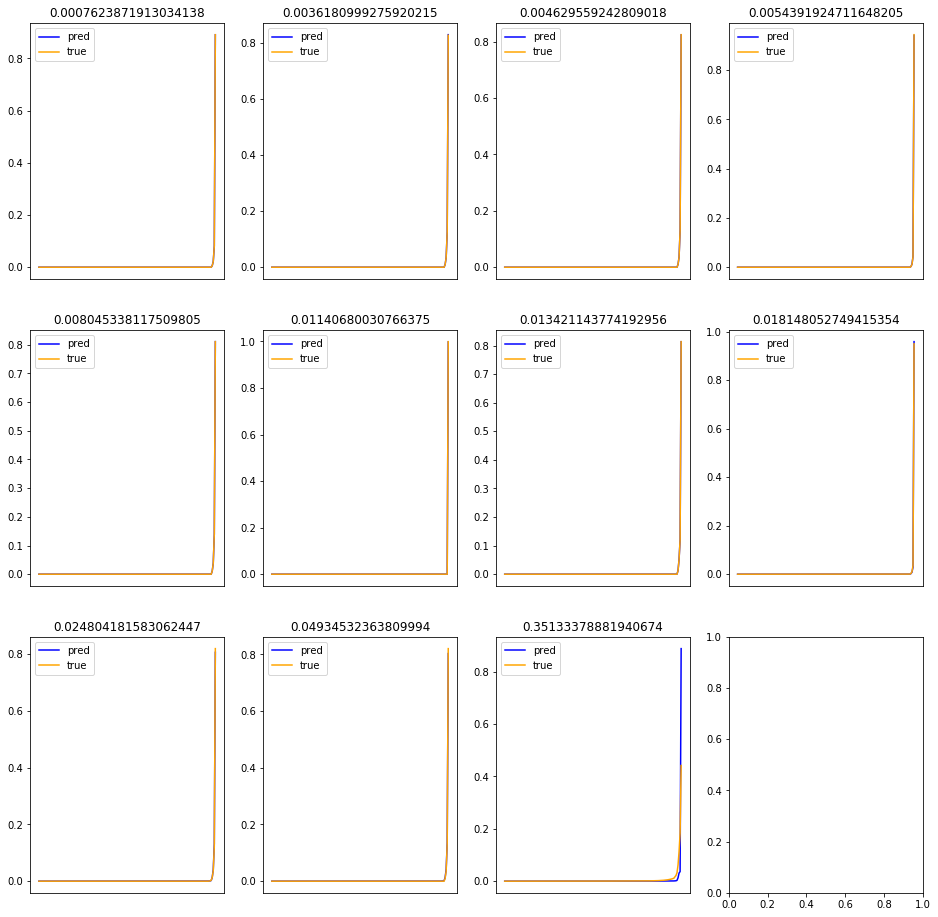

In [90]:
fits_spike.sort(key=lambda t: t[2])

from matplotlib import pyplot as plt
import numpy as np
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 16))

for idx, ax in enumerate(axes.flatten()):
    # The first and the last will be the min and max
    if idx == 0:
        i = fits_spike[0][0]
    elif idx == 10:
        i = fits_spike[-1][0]
    elif idx == 11:
        break
    else:
        # Otherwise select the 10th, 20th, 30th etc
        i = fits_spike[int(len(preds_spike)/10)*idx][0]

    test_pred = preds_spike[i]
    true = y_test_end.iloc[i]
    ax.plot(test_pred, color='blue', label='pred')
    ax.plot(true, color='orange', label='true')
    ax.xaxis.set_visible(False)
    ax.legend(loc="upper left")
    #e = entropy(test_pred, true)
    #ax.set_title(e)
    
    # Set the title to show the entropy
    jc = jensenshannon(true, test_pred)
    ax.set_title(jc)
    
    
plt.show()

Train a seperate random forest model on the data without a spike at the end. Having one model caused the random forest to pick up on the spike more often.

In [4]:
output_is_not_end_train_idx = y_train.Output_Is_End.index[y_train['Output_Is_End'] == 0]

X = X_train.loc[output_is_not_end_train_idx]
y = y_train.loc[output_is_not_end_train_idx].drop(['Output_Is_End'], axis=1)

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=8, n_estimators=200, n_jobs=16, verbose=2, random_state=0)
rf.fit(X, y)


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 200
building tree 2 of 200building tree 3 of 200

building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  8.4min


building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67

[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed: 79.5min


building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200


[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed: 114.2min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=16, oob_score=False,
                      random_state=0, verbose=2, warm_start=False)

Training results:

For not at end, with depth = 5 and trees = 60 score of .4795

For not at end with depth = 6 and trees = 100 score of .5483

For not at end with depth = 8 and trees = 200 score of .739

Make predictions, save the model, and evaluate the fit like above for the non-spike model

In [5]:
output_is_not_end_test_idx = y_test.Output_Is_End.index[y_test['Output_Is_End'] == 0]

X_test_non = X_test.loc[output_is_not_end_test_idx]
y_test_non = y_test.loc[output_is_not_end_test_idx].drop(['Output_Is_End'], axis=1)

score = rf.score(X_test_non, y_test_non)
print(score)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    7.6s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:   11.4s finished
/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.7393084544201332


In [6]:
from joblib import dump, load
dump(rf, 'rf-model.joblib') 

['rf-model.joblib']

In [7]:
preds = rf.predict(X_test_non)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    6.9s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:   10.0s finished


In [82]:
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
# Renormalize samples
preds_normalized = []
for s in preds:
    preds_normalized.append(np.divide(s,np.sum(s)))

In [83]:
fits, js_list = evaluate_fit(preds_normalized, y_test_non)

Entropy


,0
count,118476.000000
mean,0.212379
std,0.372178
min,0.000116
25%,0.009452
50%,0.031447
75%,0.284669
max,5.523985


Jensen-Shannon


,0
count,118476.000000
mean,0.172731
std,0.155084
min,0.005382
25%,0.051637
50%,0.094461
75%,0.287355
max,0.803699


Sort the results the Jenson-Shannon entropy and graph the min, max, and each 10 percentiles.

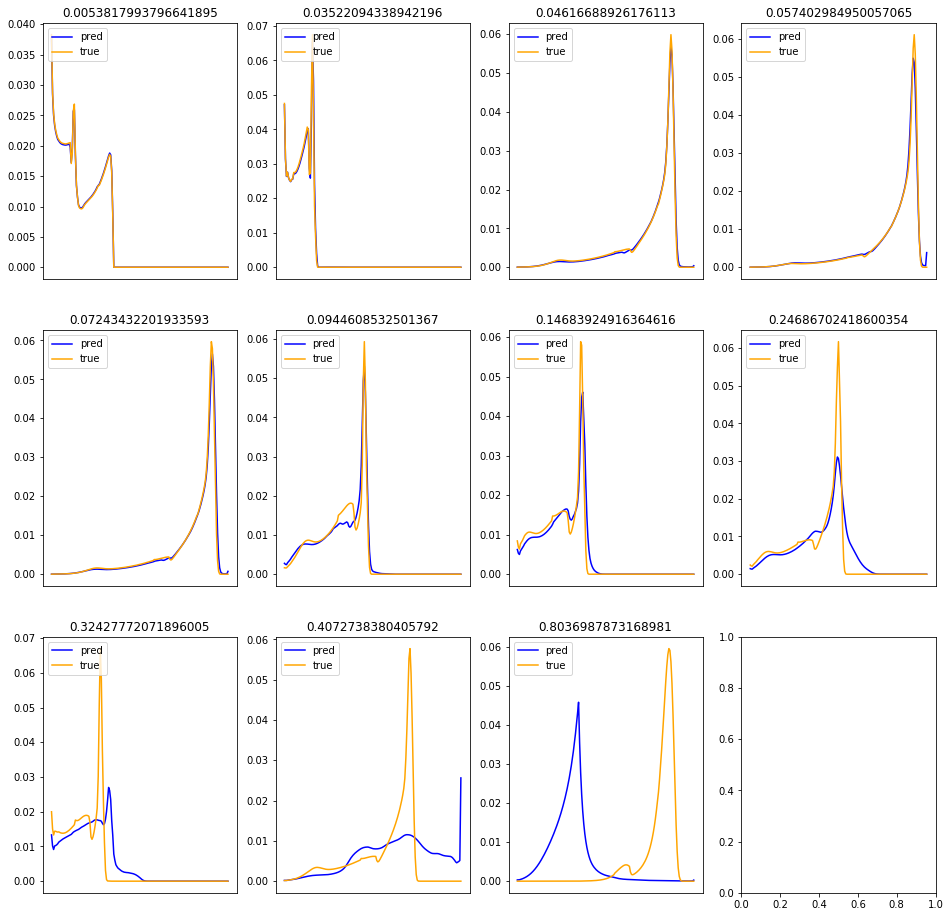

In [77]:
fits.sort(key=lambda t: t[2])

from matplotlib import pyplot as plt
import numpy as np
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 16))

for idx, ax in enumerate(axes.flatten()):
    # Generate random index to plot
    if idx == 0:
        i = fits[0][0]
    elif idx == 10:
        i = fits[-1][0]
    elif idx == 11:
        break
    else:
        i = fits[int(len(preds)/10)*idx][0]

    test_pred = preds[i]
    true = y_test_non.iloc[i]
    ax.plot(test_pred, color='blue', label='pred')
    ax.plot(true, color='orange', label='true')
    ax.xaxis.set_visible(False)
    ax.legend(loc="upper left")
    #e = entropy(test_pred, true)
    jc = jensenshannon(test_pred,true)
    ax.set_title(jc)
    #ax.set_title(e)
    
plt.show()


Show the distributions of entropy. Most are skewed toward 0

0.8036987873168981


(array([5.80706122, 1.95165216, 0.98201123, 1.28725093, 1.20901145,
        0.7189574 , 0.34097612, 0.15425865, 0.06259159, 0.01258175]),
 array([0.0053818 , 0.0852135 , 0.1650452 , 0.2448769 , 0.32470859,
        0.40454029, 0.48437199, 0.56420369, 0.64403539, 0.72386709,
        0.80369879]),
 <a list of 10 Patch objects>)

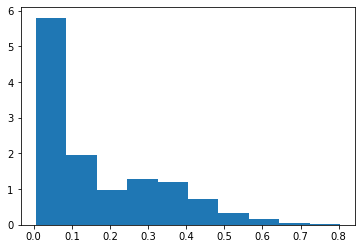

In [84]:
plt.hist(js_list, bins=10, density=True)

This will randomnly select test and predictions and graph them

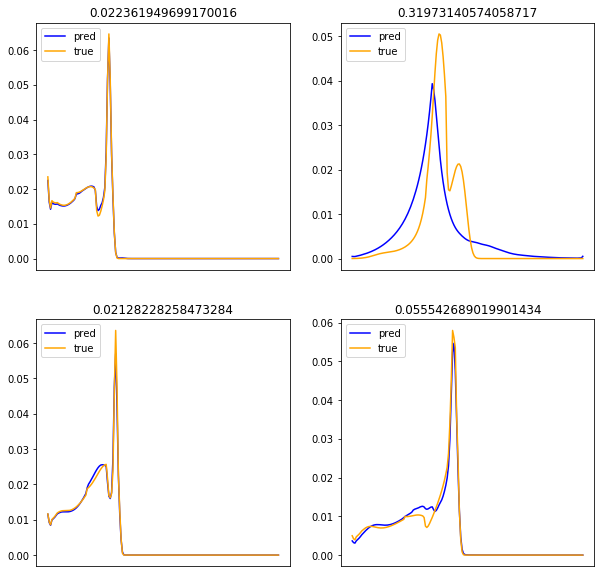

In [39]:
from matplotlib import pyplot as plt
import numpy as np
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for ax in axes.flatten():
    # Generate random index to plot
    i = np.random.randint(len(y_test_non), size=1)[0]
    test_pred = preds[i]
    true = y_test_non.iloc[i]
    ax.plot(test_pred, color='blue', label='pred')
    ax.plot(true, color='orange', label='true')
    ax.xaxis.set_visible(False)
    ax.legend(loc="upper left")
    #e = entropy(test_pred, true)
    jc = jensenshannon(test_pred,true)
    ax.set_title(jc)
    #ax.set_title(e)
    
plt.show()